In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('data/runs.csv')

# 2. Filter for relevant outcomes only
# We only care if it "success" (pass) or "failure" (breakage)
# We drop 'cancelled', 'skipped', etc.
valid_outcomes = ['success', 'failure']
df = df[df['conclusion'].isin(valid_outcomes)].copy()

# 3. Create Target: 1 = Failure (Breakage), 0 = Success
df['target'] = (df['conclusion'] == 'failure').astype(int)

# 4. Feature Engineering: Time
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek # 0=Mon, 6=Sun

print(f"Cleaned dataset size: {len(df)} rows")
print("Failure Rate:", df['target'].mean().round(3))

Cleaned dataset size: 26851 rows
Failure Rate: 0.171


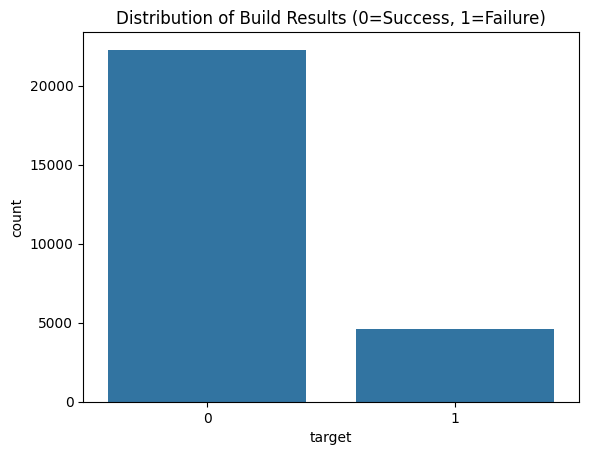

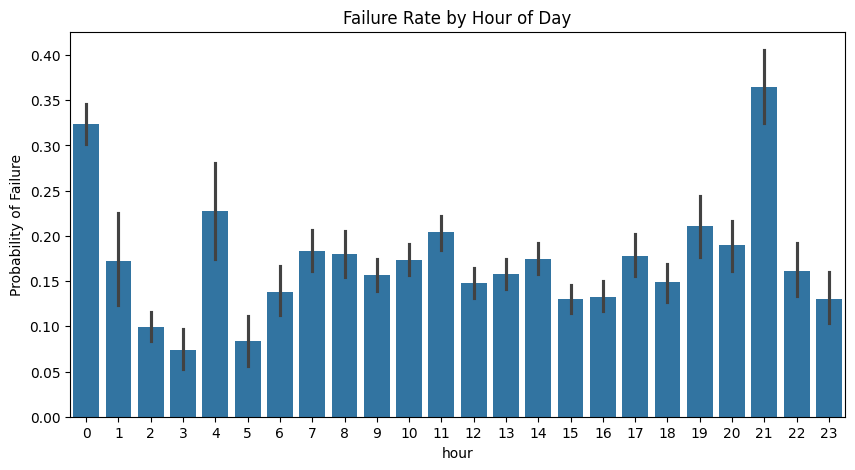

In [3]:
# Chart 1: Target Distribution
# Is the dataset balanced? (Usually failure is rare)
sns.countplot(x=df['target'])
plt.title("Distribution of Build Results (0=Success, 1=Failure)")
plt.show()

# Chart 2: Failures by Hour of Day
# Do developers break things more often late at night?
plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='target', data=df)
plt.title("Failure Rate by Hour of Day")
plt.ylabel("Probability of Failure")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# 1. Select Features
# specific 'author' and 'repo' are high-cardinality categorical features
categorical = ['repo', 'author']
numerical = ['hour', 'day_of_week', 'run_attempt']

# 2. Split Data (60% Train, 20% Val, 20% Test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

# 3. Vectorize (Convert text to numbers)
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

print(f"Training shape: {X_train.shape}")

Training shape: (16110, 535)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Model 1: Logistic Regression (Baseline)
lr = LogisticRegression(solver='liblinear', C=1.0)
lr.fit(X_train, y_train)
auc_lr = roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1])
print(f"Logistic Regression AUC: {auc_lr:.4f}")

# Model 2: Random Forest (Challenger)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
auc_rf = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])
print(f"Random Forest AUC: {auc_rf:.4f}")

Logistic Regression AUC: 0.8504
Random Forest AUC: 0.8327


In [6]:
# --- HYPERPARAMETER TUNING (Rubric: 3 Points) ---

print("Tuning Random Forest...")
best_auc = 0
best_depth = 0

# Try different depths to see which is best
for depth in [5, 10, 15, 20]:
    rf_tune = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=1, n_jobs=-1)
    rf_tune.fit(X_train, y_train)
    
    y_pred_tune = rf_tune.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_tune)
    
    print(f"Depth: {depth} -> AUC: {auc:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        best_depth = depth

print(f"Best Random Forest Depth: {best_depth} with AUC: {best_auc:.4f}")

print("\nTuning Logistic Regression...")
# Try different regularization strengths (C)
for c_val in [0.01, 0.1, 1.0, 10.0]:
    lr_tune = LogisticRegression(solver='liblinear', C=c_val)
    lr_tune.fit(X_train, y_train)
    
    y_pred_lr = lr_tune.predict_proba(X_val)[:, 1]
    auc_lr = roc_auc_score(y_val, y_pred_lr)
    
    print(f"C: {c_val} -> AUC: {auc_lr:.4f}")

Tuning Random Forest...
Depth: 5 -> AUC: 0.7903
Depth: 10 -> AUC: 0.8327
Depth: 15 -> AUC: 0.8498
Depth: 20 -> AUC: 0.8476
Best Random Forest Depth: 15 with AUC: 0.8498

Tuning Logistic Regression...
C: 0.01 -> AUC: 0.7972
C: 0.1 -> AUC: 0.8362
C: 1.0 -> AUC: 0.8504
C: 10.0 -> AUC: 0.8549
